In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import abc

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch import Tensor


from models.ridge_ALOOCV import fit_ridge_ALOOCV
from models.sandwiched_least_squares import sandwiched_LS_dense, sandwiched_LS_diag, sandwiched_LS_scalar

def acc_from_logits(logits, y, n_classes):
    if n_classes==2:
        pred = (logits>0).float()
    else:
        pred = torch.argmax(logits, dim=1, keepdim=True)
    acc = (pred==y).float().mean()
    return acc

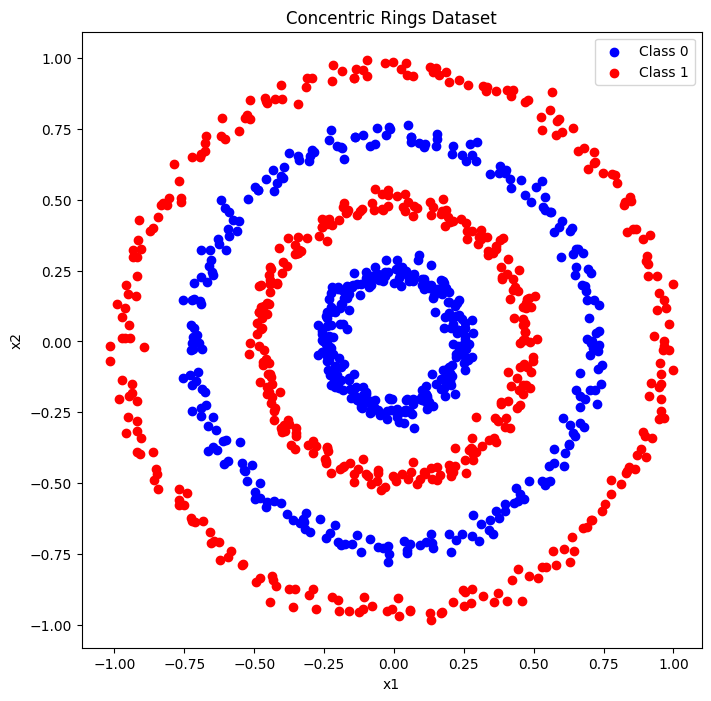

In [ ]:
import matplotlib.pyplot as plt

def generate_concentric_rings(n: int, samples_per_ring: int) -> Tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(2 * n):
        radius = i + 1
        theta = np.linspace(0, 2 * np.pi, samples_per_ring)
        x1 = radius * np.cos(theta) + np.random.randn(samples_per_ring) * 0.1
        x2 = radius * np.sin(theta) + np.random.randn(samples_per_ring) * 0.1
        X.append(np.vstack((x1, x2)).T)
        y.append(np.full(samples_per_ring, i % 2))
    X = np.vstack(X)
    y = np.hstack(y)
    perm = np.random.permutation(len(X))
    X = X[perm] / np.max(X)
    y = y[perm]

    #plot
    plt.figure(figsize=(8, 8))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
    plt.legend()
    plt.title('Concentric Rings Dataset')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

    y = y[..., None].astype(float)
    y = torch.tensor(y).float()
    X = torch.tensor(X).float()
    X_train, y_train, X_test, y_test = X[:int(0.8 * len(X))], y[:int(0.8 * len(y))], X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]
    return X_train, y_train, X_test, y_test



def make_spirals_dataset_Rd(n_samples=1000, n_classes=3, noise=0.1, D=3, train_test_ratio=0.8):
    samples_per_class = n_samples // n_classes
    n_samples = samples_per_class * n_classes
    X = []
    y = []
    
    # First create 2D spirals
    original_2d_spiral = []
    for i in range(n_classes):
        t = torch.linspace(0, 4*torch.pi, samples_per_class)
        r = (t + 1)/torch.max(t)
        angle_offset = 2*torch.pi * i / n_classes
        
        # Create initial 2D spiral
        spiral_2d = torch.stack([
            r * torch.cos(t + angle_offset),
            r * torch.sin(t + angle_offset)
        ], dim=1)
        original_2d_spiral.append(spiral_2d)

        # Project to higher dimensions using random orthogonal matrix
        Q = torch.nn.init.orthogonal_(torch.randn(D, D))
        X_class = torch.zeros(samples_per_class, D)
        X_class[:, :2] = spiral_2d
        X_class = X_class @ Q + torch.randn(samples_per_class, D) * noise
        
        X.append(X_class)
        y.append(torch.full((samples_per_class,), i))
    
    X = torch.cat(X)
    y = torch.cat(y)
    if n_classes > 2:
        y = torch.nn.functional.one_hot(y, n_classes).float()
    else:
        y = y.unsqueeze(1).float()
    
    # Shuffle
    perm = torch.randperm(n_samples)
    size = int(n_samples * train_test_ratio)
    X = X[perm]
    y = y[perm]

    #plot original spiral, non-transformed by Q:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 8))
    for i, spiral in enumerate(original_2d_spiral):
        plt.scatter(spiral[:, 0], spiral[:, 1], label=f'Class {i}')
    plt.legend()
    plt.title('Original 2D Spirals')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    return X[:size], y[:size], X[size:], y[size:]



# Generate dataset
n_classes = 2
D = 10
# X_train, y_train, X_test, y_test = make_spirals_dataset_Rd(
#     n_samples=1000, n_classes=n_classes, noise=0.1, D=D, train_test_ratio=0.8
#     )
X_train, y_train, X_test, y_test = generate_concentric_rings(n=2, samples_per_ring=1000//4)
if n_classes > 2:
    loss_fn = nn.functional.cross_entropy
else:
    loss_fn = nn.functional.binary_cross_entropy_with_logits

# TODO do this for regression. look at paper that claims that resnets cannot solve this, they clearly can!

In [3]:
from models.base import LogisticRegression
    
model = LogisticRegression(
    n_classes, l2_lambda=0.01, max_iter=300
     )

results = []
for i in range(5):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

train ce tensor(0.6926) std tensor(7.8850e-08)
test ce tensor(0.6970) std tensor(1.0190e-06)
train acc tensor(0.4275) std tensor(0.)
test acc tensor(0.4200) std tensor(0.)


In [4]:
from models.random_feature_representation_boosting import GradientRFRBoostClassifier

model = GradientRFRBoostClassifier(
        in_dim=D,
        n_classes=n_classes,
        hidden_dim=128,
        n_layers=3,
        randfeat_xt_dim=128,
        randfeat_x0_dim=128,
        l2_cls=0.01,
        l2_ghat=0.0001,
        boost_lr=1.0,
        feature_type="SWIM",
        upscale_type="SWIM",
        lbfgs_lr=1.0,
        lbfgs_max_iter=300,
    )

results = []
for i in range(5):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

tensor(0.)
tensor(0.)
tensor(0.)
linesearch loss tensor(0.5806, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.4616, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.1422, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.1054, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0794, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0688, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0640, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0625, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0622, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0622, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
linesearch loss tensor(0.0622, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.)
tensor(0.)
linesearch loss tensor(0.0301, grad_fn=<BinaryCrossEntropyWithLog

In [5]:
def see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn):
    with torch.no_grad():
        X0_train = X_train
        X0_test = X_test

        X_train = model.upscale(X0_train)
        X_test = model.upscale(X0_test)

        pred_train = model.top_level_modules[0](X_train)
        pred_test = model.top_level_modules[0](X_test)

        ce_train = loss_fn(pred_train, y_train)
        ce_test = loss_fn(pred_test, y_test)
        acc_train = acc_from_logits(pred_train, y_train, n_classes)
        acc_test = acc_from_logits(pred_test, y_test, n_classes)
        print(f"Train ce at layer 0: {ce_train}")
        print(f"Test ce at layer 0: {ce_test}")
        print(f"Train acc at layer 0: {acc_train}")
        print(f"Test acc at layer 0: {acc_test}")
        print()
        
        for t, (feat_layer, ghat_layer, classifier) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.top_level_modules[1:])):
            features_train = feat_layer(X_train, X0_train)
            features_test = feat_layer(X_test, X0_test)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            
            pred_train = classifier(X_train)
            pred_test = classifier(X_test)

            ce_train = loss_fn(pred_train, y_train)
            ce_test = loss_fn(pred_test, y_test)
            acc_train = acc_from_logits(pred_train, y_train, n_classes)
            acc_test = acc_from_logits(pred_test, y_test, n_classes)
            print(f"Train ce at layer {t+1}: {ce_train}")
            print(f"Test ce at layer {t+1}: {ce_test}")
            print(f"Train acc at layer {t+1}: {acc_train}")
            print(f"Test acc at layer {t+1}: {acc_test}")
            print()

see_results_for_every_layer(X_train, y_train, X_test, y_test, model, loss_fn)


Train ce at layer 0: 0.5770078301429749
Test ce at layer 0: 0.6563062071800232
Train acc at layer 0: 0.5287500023841858
Test acc at layer 0: 0.41999998688697815

Train ce at layer 1: 0.0185265950858593
Test ce at layer 1: 0.028069352731108665
Train acc at layer 1: 0.9975000023841858
Test acc at layer 1: 0.9900000095367432

Train ce at layer 2: 0.005235620774328709
Test ce at layer 2: 0.0077707176096737385
Train acc at layer 2: 1.0
Test acc at layer 2: 1.0

Train ce at layer 3: 0.0025194978807121515
Test ce at layer 3: 0.003307526931166649
Train acc at layer 3: 1.0
Test acc at layer 3: 1.0



# End2End

In [6]:
from old.models import End2EndMLPResNet

model = End2EndMLPResNet(
        in_dim=2,
        hidden_dim=128,
        bottleneck_dim=32,
        out_dim= (n_classes if n_classes>2 else 1),
        n_blocks=3,
        loss = "bce",
        lr = 0.01,
        n_epochs = 60,
        end_lr_factor= 0.01,
        weight_decay = 0.001,
        batch_size = 64,
        )

results = []
for i in range(5):
    model.fit(X_train, y_train)
    out_train = model(X_train)
    out_test = model(X_test)
    ce_train = loss_fn(out_train, y_train)
    ce_test = loss_fn(out_test, y_test)
    acc_train = acc_from_logits(out_train, y_train, n_classes)
    acc_test = acc_from_logits(out_test, y_test, n_classes)
    results.append(torch.tensor([ce_train, ce_test, acc_train, acc_test]))
results = torch.stack(results)
print("train ce", results[:, 0].mean(), "std", results[:, 0].std())
print("test ce", results[:, 1].mean(), "std", results[:, 1].std())
print("train acc", results[:, 2].mean(), "std", results[:, 2].std())
print("test acc", results[:, 3].mean(), "std", results[:, 3].std())

100%|██████████| 60/60 [00:03<00:00, 18.70it/s]

train ce tensor(0.0197) std tensor(0.0108)
test ce tensor(0.0706) std tensor(0.0384)
train acc tensor(0.9997) std tensor(0.0006)
test acc tensor(0.9910) std tensor(0.0124)


In [7]:
instead, try to separate the points to 1,1 and -1-1

SyntaxError: invalid syntax (1231381864.py, line 1)

# 2n Spirals dataset